In [3]:
import os
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
from scipy.sparse import vstack, hstack
from collections import deque

# read in data

In [ ]:
mtx_path = '/public21/home/sc90258/huangying/analysis/12.pan_mosquito/20241225_rerun_mtx-stand_by/2.alb/2.mtx/shell/alb/outs/filtered'
adata = sc.read_10x_mtx(mtx_path)

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 19715 × 24861
    var: 'gene_ids', 'feature_types'

In [3]:
adata.var_names

Index(['LOC134284185', 'LOC109417417', 'LOC109417254', 'LOC134288904',
       'LOC134288997', 'LOC109405218', 'LOC109412858', 'LOC134283944',
       'LOC109405206', 'LOC134288272',
       ...
       'KEG16_t18', 'KEG16_t19', 'KEG16_p03', 'KEG16_p02', 'KEG16_t20',
       'KEG16_p01', 'KEG16_t21', 'KEG16_r02', 'KEG16_t22', 'KEG16_r01'],
      dtype='object', length=24861)

# QC

## mark mitochondrial genes

In [4]:
# mitochondrial genes
mt_genes = ['KEG16_t01', 'KEG16_t02', 'KEG16_t03', 'KEG16_p13', 'KEG16_t04', 'KEG16_t05', 'KEG16_t06', 'KEG16_p12', 'KEG16_t07', 'KEG16_p11', 'KEG16_t08', 'KEG16_t09', 'KEG16_p10', 'KEG16_p09', 'KEG16_p08', 'KEG16_t10', 'KEG16_p07', 'KEG16_t11', 'KEG16_t12', 'KEG16_t13', 'KEG16_t14', 'KEG16_t15', 'KEG16_t16', 'KEG16_p06', 'KEG16_t17', 'KEG16_p05', 'KEG16_p04', 'KEG16_t18', 'KEG16_t19', 'KEG16_p03', 'KEG16_p02', 'KEG16_t20', 'KEG16_p01', 'KEG16_t21', 'KEG16_r02', 'KEG16_t22', 'KEG16_r01']

adata.var["mt"] = adata.var_names.map(lambda x: str(x) in mt_genes)

## calculate QC metrics

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 19715 × 24861
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [6]:
adata.obs['pct_counts_mt'].median()

np.float32(5.4590573)

## plot QC plot before do filtering 

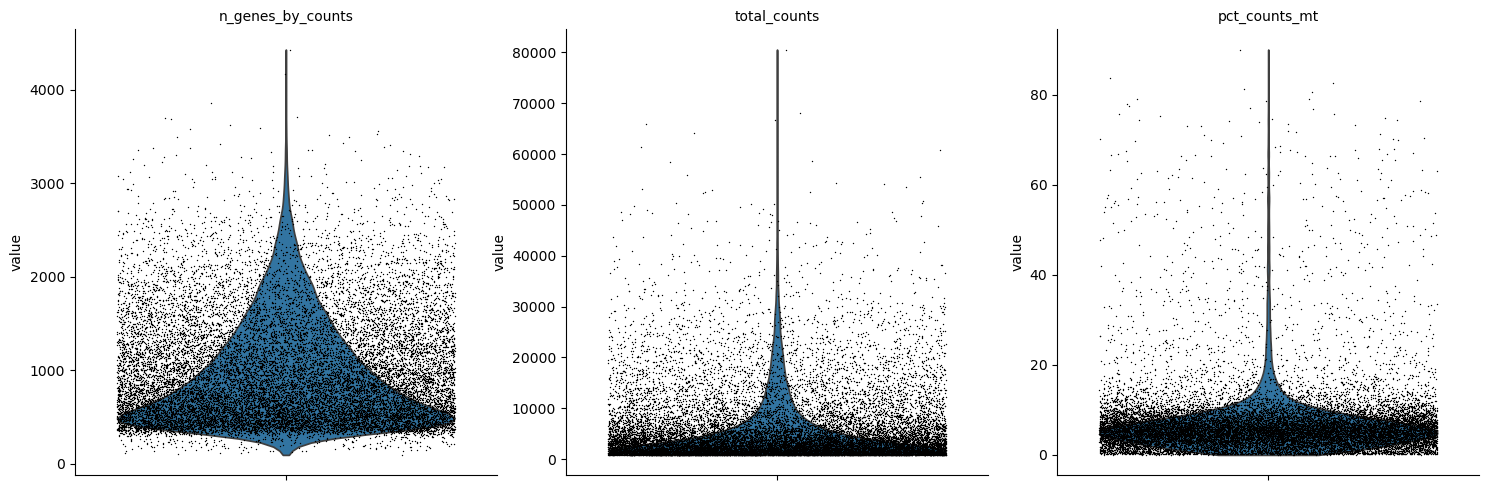

In [7]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

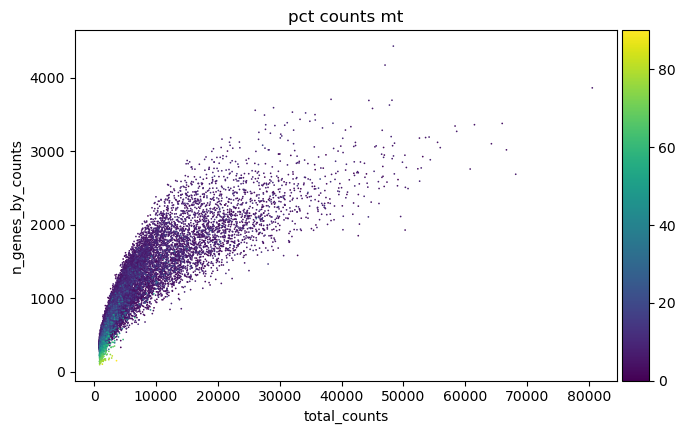

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## plot QC plot after do filtering 

In [9]:
# maximum percent.mt
max_percent_mt = 15

adata.obs["mt_outlier"] = (
    adata.obs["pct_counts_mt"] > max_percent_mt
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    18538
True      1177
Name: count, dtype: int64

In [10]:
# QC thresholds
min_n_genes_by_counts = 100
# maximum nFeature_RNA
max_n_genes_by_counts = 2500


adata.obs["genes_outlier"] = \
    (adata.obs.n_genes_by_counts < min_n_genes_by_counts) | \
    (adata.obs.n_genes_by_counts > max_n_genes_by_counts)
adata.obs.genes_outlier.value_counts()

genes_outlier
False    19380
True       335
Name: count, dtype: int64

In [11]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[
    (~adata.obs.mt_outlier) & \
    (~adata.obs.genes_outlier)
].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 19715
Number of cells after filtering of low quality cells: 18208


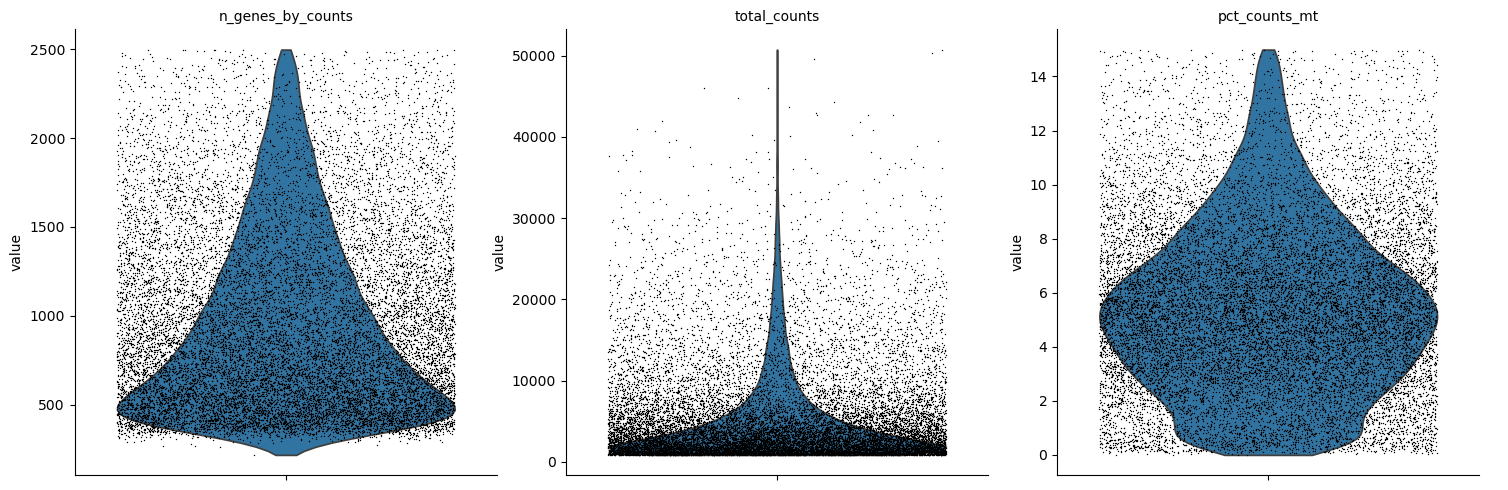

In [12]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

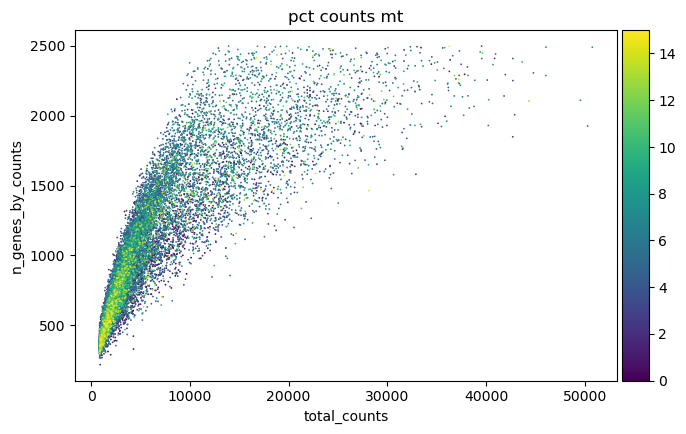

In [13]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [14]:
adata.obs.n_genes_by_counts.median()

np.float64(827.0)

In [15]:
adata.obs.total_counts.median()

np.float32(3216.0)

## write QC data for doublets check

In [16]:
Rscript = """library(dplyr)
library(Seurat)
library(ggplot2)
library(future)
library(Cairo)
library(DoubletFinder)
library(Matrix)
library(SeuratDisk)

args <- commandArgs(trailingOnly = TRUE)

## read in file --------------------------------------------------------
# path to 10x directory
ipath = args[1]
# 'project' in 'CreateSeuratObject'
project = 'midgut'
# read in file
data10x = Read10X(
    data.dir = ipath
)
# make Seurat object of RNA data
# create Seurat object
seurat_obj =  CreateSeuratObject(
    counts = data10x, 
    assay = "RNA",
    project = project, 
    min.cells = 3
)
## do normalization --------------------------------------------------------
seurat_obj <- NormalizeData(seurat_obj, normalization.method = "LogNormalize", scale.factor = 10000)
# feature selection
# Identification of highly variable features
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)
# scaling data
all.genes <- rownames(seurat_obj)
seurat_obj <- ScaleData(seurat_obj, features = all.genes)

## PCA reduce dimension ----------------------------------------------------
seurat_obj <- RunPCA(seurat_obj, features = VariableFeatures(object = seurat_obj))
# runUMAP
seurat_obj <- RunUMAP(seurat_obj, dims = 1:50)

# https://cloud.tencent.com/developer/article/1825672
nExp <- round(ncol(seurat_obj) * 0.04)  # expect 4% doublets
data.filt <- doubletFinder_v3(
    seurat_obj, 
    pN = 0.25, # https://cloud.tencent.com/developer/article/1825672
    pK = 0.09, 
    nExp = nExp, 
    PCs = 1:50)

DF.name = colnames(data.filt@meta.data)[grepl("DF.classification", colnames(data.filt@meta.data))]

DimPlot(data.filt, group.by = DF.name)

# save seurat_obj
opath_seurat_obj = './mark_doublet/mark_doublet.seurat_obj.rds'
saveRDS(data.filt, file = opath_seurat_obj)
# write h5ad file
SaveH5Seurat(data.filt, filename = "./mark_doublet/mark_doublet.seurat_obj.h5Seurat")
Convert("./mark_doublet/mark_doublet.seurat_obj.h5Seurat", dest = "h5ad")
"""

In [17]:
os.mkdir('./mark_doublet')
with open('./mark_doublet/DoubletFinder.R', 'wt') as f:
    f.write(Rscript)
os.system(f'~/miniconda3/envs/hy-seurat/bin/Rscript ./mark_doublet/DoubletFinder.R {mtx_path}')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Attaching SeuratObject
Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix
  |========================================

[1] "Creating 6572 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Finding variable genes..."


Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Scaling data..."


Centering and scaling data matrix
  |======================================================================| 100%


[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Creating h5Seurat file for version 3.1.5.9900
Adding counts for RNA
Adding data for RNA
Adding scale.data for RNA
Adding variable features for RNA
Adding feature-level metadata for RNA
Adding cell embeddings for pca
Adding loadings for pca
No projected loadings for pca
Adding standard deviations for pca
No JackStraw data for pca
Adding cell embeddings for umap
No loadings for umap
No projected loadings for umap
No standard deviations for umap
No JackStraw data for umap
Validating h5Seurat file
Adding scale.data from RNA as X
Transfering meta.features to var
Adding data from RNA as raw
Transfering meta.features to raw/var
Transfering meta.data to obs
Adding dimensional reduction information for pca
Adding feature loadings for pca
Adding dimensional reduction information for umap


0

## remove doublets

In [18]:
# read in data marked doublets
dblets = sc.read('./mark_doublet/mark_doublet.seurat_obj.h5ad')
dblets

AnnData object with n_obs × n_vars = 19715 × 15426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pANN_0.25_0.09_789', 'DF.classifications_0.25_0.09_789'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [19]:
# remove doublets
dblets_col = [i for i in dblets.obs.columns if i.startswith('DF.classifications_')][0]
sglets_obs = dblets.obs[dblets.obs[dblets_col] == 'Singlet'].index
adata = adata[adata.obs.index.isin(sglets_obs)]
adata

View of AnnData object with n_obs × n_vars = 17538 × 24861
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## save AnnData after QC

In [20]:
# save data
adata.write("1.QC.h5ad")
# show AnnData
adata

View of AnnData object with n_obs × n_vars = 17538 × 24861
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

# Normalization

In [21]:
# read in data
adata = sc.read('./1.QC.h5ad')
adata

AnnData object with n_obs × n_vars = 17538 × 24861
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [22]:
# normalization 
sc.pp.normalize_total(
    adata, 
    target_sum=1e6, 
    exclude_highly_expressed=True
)
# Logarithmize
sc.pp.log1p(adata)

# show AnnData
adata

AnnData object with n_obs × n_vars = 17538 × 24861
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [23]:
# save data
adata.write("2.normalization.h5ad")

# Feature Selection

In [24]:
# read in data
adata = sc.read('./2.normalization.h5ad')
adata

AnnData object with n_obs × n_vars = 17538 × 24861
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [25]:
# find highly variable genes
sc.pp.highly_variable_genes(
    adata, n_top_genes=4000, 
    flavor='seurat_v3'
)
# save original AnnData to `.raw` attribute
adata.raw = adata
# only keeping highly variable genes in AnnData
adata = adata[:, adata.var.highly_variable]
# scale each gene to unit variance
sc.pp.scale(adata)
# show AnnData
adata

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 17538 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [26]:
# save data
adata.write("3.after_feature_selection.h5ad")

# dimensional reduction

In [27]:
# read in data
adata = sc.read('./3.after_feature_selection.h5ad')
adata

AnnData object with n_obs × n_vars = 17538 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


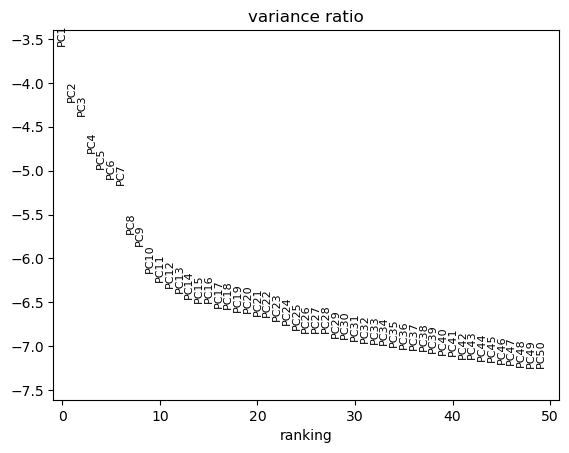

In [28]:
# run PCA
sc.pp.pca(adata, svd_solver="auto", use_highly_variable=True)
# plot single PCs to the total variance in the data
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

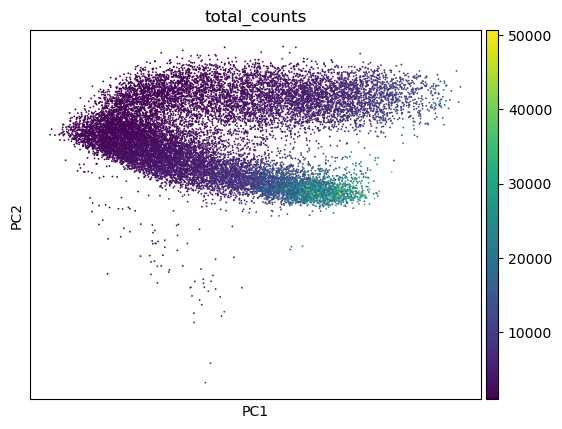

In [29]:
sc.pl.pca_scatter(adata, color="total_counts")

In [30]:
# save data
adata.write("4.PCA.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 17538 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# clustering

In [2]:
# read in data
adata = sc.read('./4.PCA.h5ad')
adata

AnnData object with n_obs × n_vars = 17538 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## plot UMAP

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_29136/2706160960.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


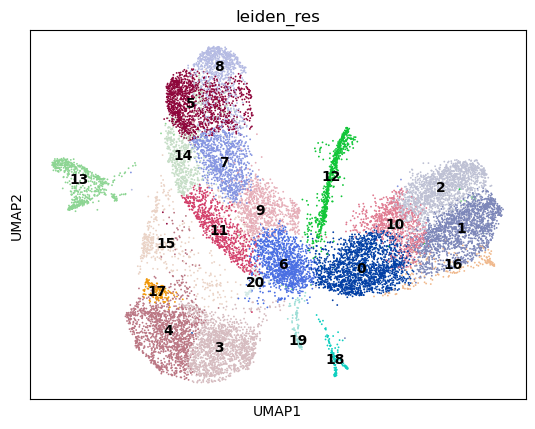

In [32]:
adata = sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30, copy=True)
sc.tl.umap(
    adata, 
    min_dist=0.3
)
sc.tl.leiden(
    adata, 
    key_added="leiden_res", 
    resolution=1.2,
)
sc.pl.umap(
    adata,
    color=["leiden_res"],
    legend_loc="on data",
)

In [33]:
adata.obs['leiden_res'].value_counts()

leiden_res
0     1823
1     1684
2     1521
3     1472
4     1385
5     1372
6     1267
7      933
8      792
9      770
10     757
11     740
12     668
13     627
14     581
15     475
16     174
17     152
18     142
19     130
20      73
Name: count, dtype: int64

In [34]:
# save data
adata.write("5.cluster.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 17538 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden_res', 'leiden_res_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Annotation

In [4]:
# read in data
adata = sc.read('./5.cluster.h5ad')
adata

AnnData object with n_obs × n_vars = 17538 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden_res', 'leiden_res_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
var_to_add = ['Ctri09956', 'LOC110674010', 'LOC5573855', 'LOC5563695']
obs_to_add = ['EC-like-3', 'EE-3', 'EE-4', 'FBC', 'ISC/EB']

var_new_dt = scipy.sparse.csr_matrix(
    np.zeros(
        (adata.n_obs, len(var_to_add))
    )
)
obs_new_dt = scipy.sparse.csr_matrix(
    np.zeros(
        (len(obs_to_add), adata.raw.n_vars + len(var_to_add))
    )
)

var_new = pd.DataFrame(index=list(adata.raw.var_names) + var_to_add)
obs_new = pd.concat([adata.obs[['leiden_res']], pd.DataFrame(obs_to_add, index=obs_to_add, columns=['leiden_res'])])

new_X = hstack([adata.raw.X, var_new_dt], format="csr")
new_X = vstack([new_X, obs_new_dt], format='csr')

adata_plt = ad.AnnData(
    X=new_X,
    obs=obs_new,
    var=var_new,
)
adata_plt

AnnData object with n_obs × n_vars = 17543 × 24865
    obs: 'leiden_res'

In [6]:
adata = adata_plt

## make marker genes dict (Culex pipiens pallens)

In [7]:
aae_homo = pd.read_csv('/public21/home/sc90258/huangying/analysis/12.pan_mosquito/20240830_homo_gene/Aalb_aae.homog.csv')
aae_homo

,alb,aae
0,KEG16_p01,CFI06_mgp01
1,KEG16_p02,CFI06_mgp02
2,LOC134284470,CFI06_mgp03
3,KEG16_p04,CFI06_mgp04
4,KEG16_p05,CFI06_mgp05
...,...,...
11884,LOC109420086,LOC5580327
11885,LOC115256042,LOC5580328
11886,LOC109420083,LOC5580329
11887,LOC109420082,LOC5580330


In [8]:
marker_genes_raw = {
    'ISC/EB': ['LOC5563695', 'LOC5578162', 'LOC5580156', 'LOC5570443', 'LOC110676293', 'LOC5580247'], # fibulin-1, Klu, Delta, esg
    'Cardia': ['LOC5564993', 'LOC5572257', 'LOC5579458'], # GAM1, chymotrypsin-2, LYZ1 , ['LOC5568253', 'LOC5572257'] FCN3, CTRB2
    'EC': ['LOC23687865', 'LOC5573855', 'LOC110676249'], # Nub, CPA-VII, CG1139
    'EC-like': ['LOC5571803', 'LOC5574806', 'LOC5572376', 'Ctri09956', 'LOC5579996', 'LOC5570613'], # CAH7, Cht10, BTBD3, KLK7, MAP7, SNAT1, LYZL
    'EE': ['LOC5575988', 'LOC5569132', 'LOC5575886', 'LOC5573874', 'LOC5565599', 'LOC5573386', 'LOC5571151', 'LOC5568255'], # prospero, npf, orcokinin, Calexcitin-1, SCG5, CABP, FGB/G
    'VM':['LOC5571832'], # actin
    'FBC':['LOC5571084'], # apolipophorin-3
    'HC':['LOC5570883', 'LOC110674010'], # LRIM16, NimB2
}

In [9]:
mg_homo = []
for k, v in marker_genes_raw.items():
    print(f'{k}:')
    for g in v:
        res = aae_homo[aae_homo['aae'] == g]
        if res.empty:
            print(f'{g}: NA')
        else:
            print(res)
            mg_homo.append(res)
mg_homo = pd.concat(mg_homo, axis=0)
mg_homo = dict(mg_homo.iloc[:, [1,0]].values)
mg_homo

ISC/EB:
LOC5563695: NA
                alb         aae
10816  LOC109398650  LOC5578162
                alb         aae
11780  LOC109411919  LOC5580156
               alb         aae
5942  LOC109407308  LOC5570443
              alb           aae
510  LOC109424283  LOC110676293
                alb         aae
11837  LOC109427955  LOC5580247
Cardia:
               alb         aae
2583  LOC109622804  LOC5564993
               alb         aae
7112  LOC115258128  LOC5572257
                alb         aae
11499  LOC109429051  LOC5579458
EC:
               alb          aae
1644  LOC109404634  LOC23687865
LOC5573855: NA
              alb           aae
498  LOC109433016  LOC110676249
EC-like:
               alb         aae
6819  LOC109427544  LOC5571803
               alb         aae
8780  LOC109415748  LOC5574806
               alb         aae
7186  LOC109405350  LOC5572376
Ctri09956: NA
                alb         aae
11688  LOC109413956  LOC5579996
               alb         aae
6036  LOC109

{'LOC5578162': 'LOC109398650',
 'LOC5580156': 'LOC109411919',
 'LOC5570443': 'LOC109407308',
 'LOC110676293': 'LOC109424283',
 'LOC5580247': 'LOC109427955',
 'LOC5564993': 'LOC109622804',
 'LOC5572257': 'LOC115258128',
 'LOC5579458': 'LOC109429051',
 'LOC23687865': 'LOC109404634',
 'LOC110676249': 'LOC109433016',
 'LOC5571803': 'LOC109427544',
 'LOC5574806': 'LOC109415748',
 'LOC5572376': 'LOC109405350',
 'LOC5579996': 'LOC109413956',
 'LOC5570613': 'LOC109406368',
 'LOC5575988': 'LOC109398973',
 'LOC5569132': 'LOC109425743',
 'LOC5575886': 'LOC109432151',
 'LOC5573874': 'LOC109432158',
 'LOC5565599': 'LOC109408266',
 'LOC5573386': 'LOC109420023',
 'LOC5571151': 'LOC109428219',
 'LOC5568255': 'LOC109421140',
 'LOC5571832': 'LOC115267287',
 'LOC5571084': 'LOC109408437',
 'LOC5570883': 'LOC109398853'}

In [10]:
mg_homo.update(
    {
        'LOC5563695': 'LOC109621451', # Nub
    }
)
mg_homo

{'LOC5578162': 'LOC109398650',
 'LOC5580156': 'LOC109411919',
 'LOC5570443': 'LOC109407308',
 'LOC110676293': 'LOC109424283',
 'LOC5580247': 'LOC109427955',
 'LOC5564993': 'LOC109622804',
 'LOC5572257': 'LOC115258128',
 'LOC5579458': 'LOC109429051',
 'LOC23687865': 'LOC109404634',
 'LOC110676249': 'LOC109433016',
 'LOC5571803': 'LOC109427544',
 'LOC5574806': 'LOC109415748',
 'LOC5572376': 'LOC109405350',
 'LOC5579996': 'LOC109413956',
 'LOC5570613': 'LOC109406368',
 'LOC5575988': 'LOC109398973',
 'LOC5569132': 'LOC109425743',
 'LOC5575886': 'LOC109432151',
 'LOC5573874': 'LOC109432158',
 'LOC5565599': 'LOC109408266',
 'LOC5573386': 'LOC109420023',
 'LOC5571151': 'LOC109428219',
 'LOC5568255': 'LOC109421140',
 'LOC5571832': 'LOC115267287',
 'LOC5571084': 'LOC109408437',
 'LOC5570883': 'LOC109398853',
 'LOC5563695': 'LOC109621451'}

In [11]:
marker_genes = {}
for k, v in marker_genes_raw.items():
    marker_genes[k] = [mg_homo[i] if i in mg_homo.keys() else i for i in v ]
marker_genes

{'ISC/EB': ['LOC109621451',
  'LOC109398650',
  'LOC109411919',
  'LOC109407308',
  'LOC109424283',
  'LOC109427955'],
 'Cardia': ['LOC109622804', 'LOC115258128', 'LOC109429051'],
 'EC': ['LOC109404634', 'LOC5573855', 'LOC109433016'],
 'EC-like': ['LOC109427544',
  'LOC109415748',
  'LOC109405350',
  'Ctri09956',
  'LOC109413956',
  'LOC109406368'],
 'EE': ['LOC109398973',
  'LOC109425743',
  'LOC109432151',
  'LOC109432158',
  'LOC109408266',
  'LOC109420023',
  'LOC109428219',
  'LOC109421140'],
 'VM': ['LOC115267287'],
 'FBC': ['LOC109408437'],
 'HC': ['LOC109398853', 'LOC110674010']}

In [12]:
def fmt_k(x):
    if x in mg_homo.keys():
        return mg_homo[x]
    else:
        return x

g_n = {fmt_k(k): v \
    for k, v in zip(['LOC5563695', 'LOC5578162', 'LOC5580156', 'LOC5570443', 'LOC5564993', 'LOC5579458', 'LOC23687865', 'LOC5573855', 'LOC5571803', 'LOC5574806', 'LOC5570613', 'LOC110676293', 'LOC5575988', 'LOC5575886', 'LOC5569132', 'LOC5573874', 'LOC5571832', 'LOC5571084', 'LOC5570883', 'LOC110674010', 'LOC5580247', 'LOC5565599', 'LOC110676249', 'LOC5572376', 'LOC5572257', 'Ctri09956', 'LOC5579996', 'LOC5573386', 'LOC5571151', 'LOC5568255'],
    ['fibulin-1', 'Klu', 'Delta', 'esg', 'GAM1', 'LYSC', 'Nubbin', 'CPA-VII', 'CAH7', 'Cht10', 'NAAT', 'LYSC11', 'prospero', 'npf', 'orcokinin', 'Calexcitin-1', 'actin', 'apolipophorin-3', 'LRIM16', 'NimB2', 'PCNA', 'CCHa2', 'CG1139', 'BTBD3', 'chymotrypsin-2', 'KLK7', 'MAP7', 'SCG5', 'CABP', 'FGB/G'])
}
g_n

{'LOC109621451': 'fibulin-1',
 'LOC109398650': 'Klu',
 'LOC109411919': 'Delta',
 'LOC109407308': 'esg',
 'LOC109622804': 'GAM1',
 'LOC109429051': 'LYSC',
 'LOC109404634': 'Nubbin',
 'LOC5573855': 'CPA-VII',
 'LOC109427544': 'CAH7',
 'LOC109415748': 'Cht10',
 'LOC109406368': 'NAAT',
 'LOC109424283': 'LYSC11',
 'LOC109398973': 'prospero',
 'LOC109432151': 'npf',
 'LOC109425743': 'orcokinin',
 'LOC109432158': 'Calexcitin-1',
 'LOC115267287': 'actin',
 'LOC109408437': 'apolipophorin-3',
 'LOC109398853': 'LRIM16',
 'LOC110674010': 'NimB2',
 'LOC109427955': 'PCNA',
 'LOC109408266': 'CCHa2',
 'LOC109433016': 'CG1139',
 'LOC109405350': 'BTBD3',
 'LOC115258128': 'chymotrypsin-2',
 'Ctri09956': 'KLK7',
 'LOC109413956': 'MAP7',
 'LOC109420023': 'SCG5',
 'LOC109428219': 'CABP',
 'LOC109421140': 'FGB/G'}

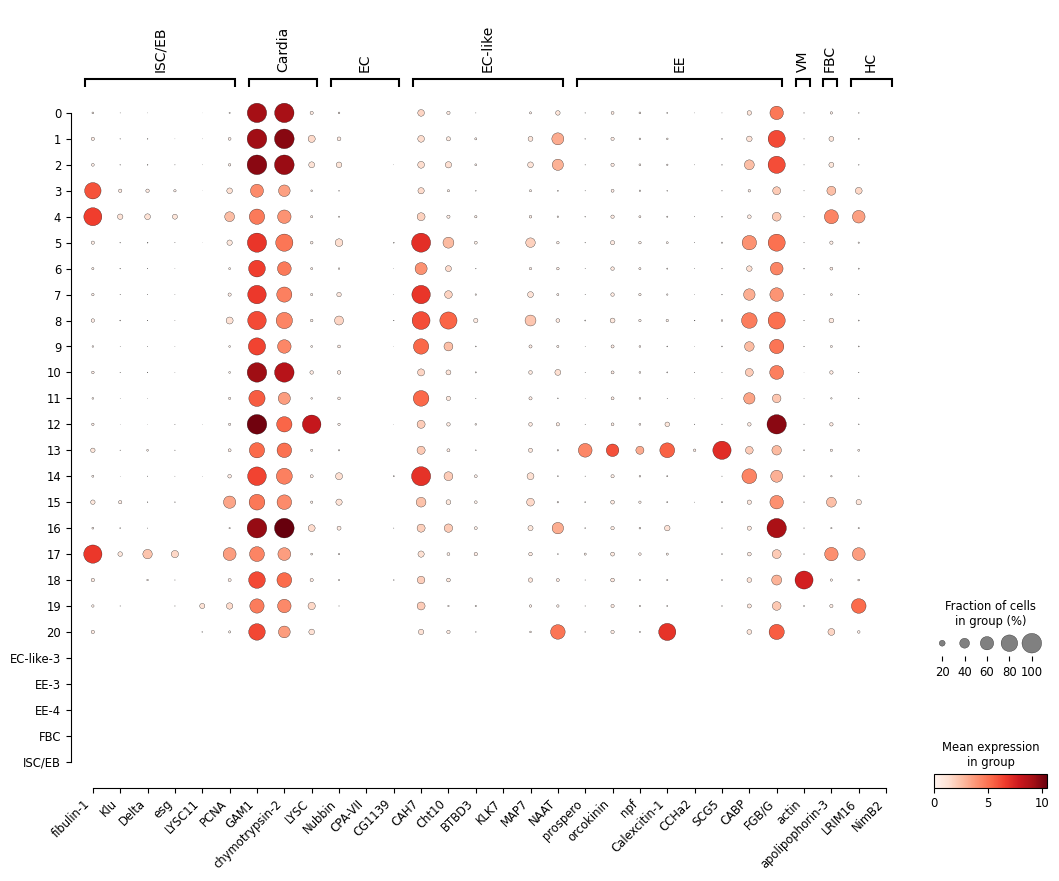

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='leiden_res',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)

In [13]:
n_id = {
    'ISC/EB': ['3'],
    'ISC/EB-prol': ['4', '17'],
    'Cardia-1': ['12'],
    'Cardia-2': ['0', '1', '2', '10', '16'],
    'EC': ['15', '14', '8', '5'],
    'EC-like-1': ['7', '9'],
    'EC-like-2': ['11', '6'],
    'EC-like-3': ['EC-like-3'],
    'EE-1': ['13'],
    'EE-2': ['20'],
    'EE-3': ['EE-3'],
    'EE-4': ['EE-4'],
    'VM': ['18'],
    'FBC': ['FBC'],
    'HC': ['19'],
}

In [14]:
id_n = {}
for k, v in n_id.items():
    for i in v:
        id_n[i] = k

id_n

{'3': 'ISC/EB',
 '4': 'ISC/EB-prol',
 '17': 'ISC/EB-prol',
 '12': 'Cardia-1',
 '0': 'Cardia-2',
 '1': 'Cardia-2',
 '2': 'Cardia-2',
 '10': 'Cardia-2',
 '16': 'Cardia-2',
 '15': 'EC',
 '14': 'EC',
 '8': 'EC',
 '5': 'EC',
 '7': 'EC-like-1',
 '9': 'EC-like-1',
 '11': 'EC-like-2',
 '6': 'EC-like-2',
 'EC-like-3': 'EC-like-3',
 '13': 'EE-1',
 '20': 'EE-2',
 'EE-3': 'EE-3',
 'EE-4': 'EE-4',
 '18': 'VM',
 'FBC': 'FBC',
 '19': 'HC'}

In [15]:
adata.obs['cluster'] = adata.obs['leiden_res'].map(
    lambda x: id_n[x] if x in id_n.keys() else x)

In [16]:
adata.obs['cluster'].unique()

array(['EC-like-1', 'EC', 'EE-1', 'ISC/EB-prol', 'Cardia-2', 'ISC/EB',
       'EC-like-2', 'VM', 'Cardia-1', 'EE-2', 'HC', 'EC-like-3', 'EE-3',
       'EE-4', 'FBC'], dtype=object)

In [17]:
adata.obs['cluster_name'] = adata.obs['cluster']
adata.obs['cluster_name'] = adata.obs['cluster_name'].astype('category')
adata.obs['cluster_name'] = adata.obs[
        'cluster_name'
    ].cat.reorder_categories(list(n_id.keys()), ordered=True)

adata.obs['cluster_name'].unique()

['EC-like-1', 'EC', 'EE-1', 'ISC/EB-prol', 'Cardia-2', ..., 'HC', 'EC-like-3', 'EE-3', 'EE-4', 'FBC']
Length: 15
Categories (15, object): ['ISC/EB' < 'ISC/EB-prol' < 'Cardia-1' < 'Cardia-2' ... 'EE-4' < 'VM' < 'FBC' < 'HC']

In [18]:
dp = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
    return_fig=True,
)

dp.dot_color_df.to_csv('./5.dot_color_df.alb.csv')
dp.dot_size_df.to_csv('./5.dot_size_df.alb.csv')

In [19]:
g_n

{'LOC109621451': 'fibulin-1',
 'LOC109398650': 'Klu',
 'LOC109411919': 'Delta',
 'LOC109407308': 'esg',
 'LOC109622804': 'GAM1',
 'LOC109429051': 'LYSC',
 'LOC109404634': 'Nubbin',
 'LOC5573855': 'CPA-VII',
 'LOC109427544': 'CAH7',
 'LOC109415748': 'Cht10',
 'LOC109406368': 'NAAT',
 'LOC109424283': 'LYSC11',
 'LOC109398973': 'prospero',
 'LOC109432151': 'npf',
 'LOC109425743': 'orcokinin',
 'LOC109432158': 'Calexcitin-1',
 'LOC115267287': 'actin',
 'LOC109408437': 'apolipophorin-3',
 'LOC109398853': 'LRIM16',
 'LOC110674010': 'NimB2',
 'LOC109427955': 'PCNA',
 'LOC109408266': 'CCHa2',
 'LOC109433016': 'CG1139',
 'LOC109405350': 'BTBD3',
 'LOC115258128': 'chymotrypsin-2',
 'Ctri09956': 'KLK7',
 'LOC109413956': 'MAP7',
 'LOC109420023': 'SCG5',
 'LOC109428219': 'CABP',
 'LOC109421140': 'FGB/G'}

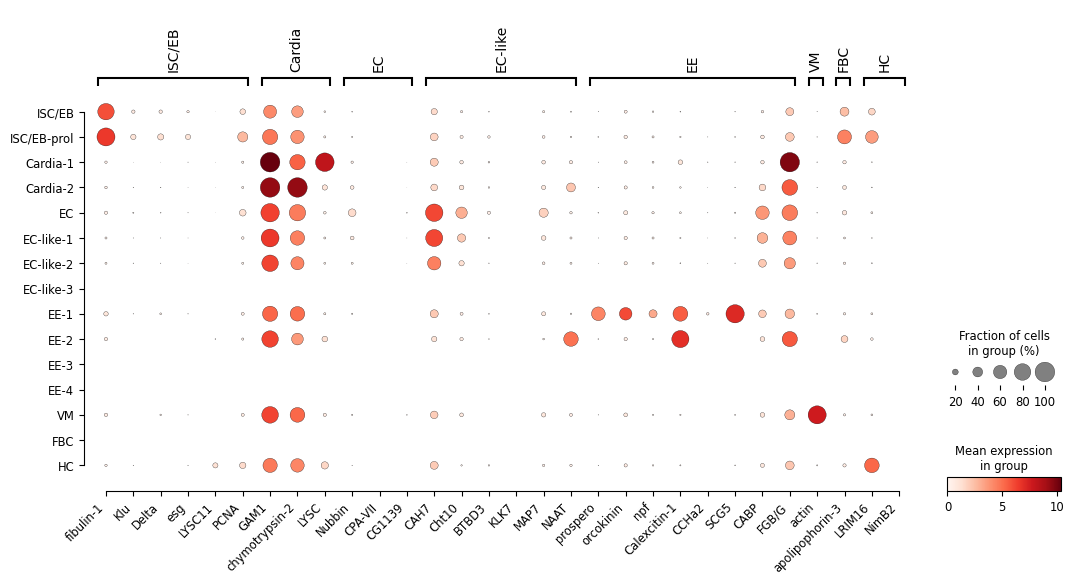

In [18]:
# save fig
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib.use('cairo')

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)
# plt.savefig('aae_dotplot.pdf', bbox_inches='tight')
# plt.close()

In [73]:
sc.tl.rank_genes_groups(
    adata, 
    "cluster_name", 
    method="wilcoxon", 
    pts=True, 
    key_added='rank_genes_groups.wilcoxon'
)

In [74]:
sc.tl.filter_rank_genes_groups(
    adata,
    key="rank_genes_groups.wilcoxon",
    key_added="rank_genes_groups.wilcoxon.filter",
)

In [75]:
adata.uns['rank_genes_groups.wilcoxon']

{'params': {'groupby': 'cluster_name',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'pts':                 ISC/EB  ISC/EB-prol  Cardia-1  Cardia-2        EC  EC-like-1  \
 LOC134284185  0.000000     0.000000  0.000000  0.000000  0.000000   0.000000   
 LOC109417417  0.038043     0.104099  0.082335  0.122000  0.254348   0.083382   
 LOC109417254  0.009511     0.026675  0.005988  0.019466  0.054348   0.021726   
 LOC134288904  0.002038     0.004554  0.001497  0.004363  0.009938   0.004698   
 LOC134288997  0.000679     0.000000  0.000000  0.000168  0.000311   0.000000   
 ...                ...          ...       ...       ...       ...        ...   
 KEG16_p01     0.242527     0.446975  0.365269  0.376405  0.679193   0.475631   
 KEG16_t21     0.000000     0.000000  0.000000  0.000000  0.000000   0.000000   
 KEG16_r02     1.000000     1.000000  1.000000  0.999161  1.000000   1.000000   
 KEG16_t22     0.0006

In [76]:
name = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['names'])
padj = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['pvals_adj'])
lgFC = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['logfoldchanges'])
scores = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon']['scores'])
pts = adata.uns['rank_genes_groups.wilcoxon.filter']['pts']
pts_rest = adata.uns['rank_genes_groups.wilcoxon.filter']['pts_rest']

dfs = []
for cluster in name.columns:
    df = pd.concat(
        [
            name[cluster].dropna(), 
            padj[cluster].dropna(), 
            lgFC[cluster].dropna(),
            scores[cluster].dropna(),
        ], 
        axis=1
    )
    df.columns = ['names', 'pvals_adj', 'logfoldchanges', 'scores']
    df.set_index(['names'], inplace=True)

    pts_df = pd.concat([pts[[cluster]], pts_rest[[cluster]]], axis=1)
    pts_df.columns = ['pts', 'pts_rest']

    df = df.merge(pts_df, left_index=True, right_index=True, how='inner')
    df['leiden_res'] = cluster

    dfs.append(df)

markg = pd.concat(dfs, axis=0)
markg = markg.sort_values(['leiden_res', 'scores'], ascending=False)

markg

,pvals_adj,logfoldchanges,scores,pts,pts_rest,leiden_res
names,,,,,,
LOC109419344,3.464999e-83,15.858278,19.806175,0.964789,0.013336,VM
LOC109425346,3.464999e-83,15.812949,19.803312,0.964789,0.011842,VM
LOC115267914,7.003986e-75,15.670903,18.794025,0.915493,0.006151,VM
LOC115253670,6.405918e-74,15.289792,18.651066,0.908451,0.006381,VM
LOC109432137,6.405918e-74,15.278357,18.648928,0.908451,0.005806,VM
...,...,...,...,...,...,...
LOC109623121,6.828665e-04,1.161088,4.290168,0.269461,0.184588,Cardia-1
LOC109432654,2.594326e-03,1.027473,3.953835,0.285928,0.208595,Cardia-1
LOC109427544,2.907274e-22,1.215372,10.090769,0.522494,0.456518,6


In [77]:
markg.to_csv('./5.marker_genes.csv')

In [19]:
n_id = {
    'ISC/EB': ['3'],
    'ISC/EB-prol': ['4', '17'],
    'Cardia-1': ['12'],
    'Cardia-2': ['0', '1', '2', '10', '16'],
    'EC': ['15', '14', '8', '5'],
    'EC-like-1': ['7', '9'],
    'EC-like-2': ['11', '6'],
    'EC-like-3': ['EC-like-3'],
    'EE-1': ['13'],
    'EE-2': ['20'],
    'EE-3': ['EE-3'],
    'EE-4': ['EE-4'],
    'VM': ['18'],
    'FBC': ['FBC'],
    'HC': ['19'],
}

In [20]:
id_n = {}
for k, v in n_id.items():
    for i in v:
        id_n[i] = k

id_n

{'3': 'ISC/EB',
 '4': 'ISC/EB-prol',
 '17': 'ISC/EB-prol',
 '12': 'Cardia-1',
 '0': 'Cardia-2',
 '1': 'Cardia-2',
 '2': 'Cardia-2',
 '10': 'Cardia-2',
 '16': 'Cardia-2',
 '15': 'EC',
 '14': 'EC',
 '8': 'EC',
 '5': 'EC',
 '7': 'EC-like-1',
 '9': 'EC-like-1',
 '11': 'EC-like-2',
 '6': 'EC-like-2',
 'EC-like-3': 'EC-like-3',
 '13': 'EE-1',
 '20': 'EE-2',
 'EE-3': 'EE-3',
 'EE-4': 'EE-4',
 '18': 'VM',
 'FBC': 'FBC',
 '19': 'HC'}

In [21]:
adata.obs['cluster'] = adata.obs['leiden_res'].map(
    lambda x: id_n[x] if x in id_n.keys() else x)

In [22]:
adata.obs['cluster'].unique()

array(['EC-like-1', 'EC', 'EE-1', 'ISC/EB-prol', 'Cardia-2', 'ISC/EB',
       'EC-like-2', 'VM', 'Cardia-1', 'EE-2', 'HC', 'EC-like-3', 'EE-3',
       'EE-4', 'FBC'], dtype=object)

In [23]:
adata.obs['cluster_name'] = adata.obs['cluster']
adata.obs['cluster_name'] = adata.obs['cluster_name'].astype('category')
adata.obs['cluster_name'] = adata.obs[
        'cluster_name'
    ].cat.reorder_categories(list(n_id.keys()), ordered=True)

adata.obs['cluster_name'].unique()

['EC-like-1', 'EC', 'EE-1', 'ISC/EB-prol', 'Cardia-2', ..., 'HC', 'EC-like-3', 'EE-3', 'EE-4', 'FBC']
Length: 15
Categories (15, object): ['ISC/EB' < 'ISC/EB-prol' < 'Cardia-1' < 'Cardia-2' ... 'EE-4' < 'VM' < 'FBC' < 'HC']

In [24]:
# save fig
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.use('cairo')

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right', fontweight='bold')
axm.set_yticklabels(
    [i.get_text() for i in axm.get_yticklabels()],
    fontweight='bold')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)
plt.savefig('aal_dotplot.pdf', bbox_inches='tight')
plt.close()

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))

# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#8B008B", "#FF4500"] # "#00CED1", 'FBC', 
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'VM', 'HC']

umap = pd.DataFrame(
    adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 0; y = 1

ax.arrow(
    x-6.5, y-3, 0, 2.2, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 3, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.8, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-2, 'UMAP-2', ha='right', va='center', rotation=90)

for i, (cell, color) in enumerate(grp_color.items()):
    x = 4; y = 12
    sep = 7
    j = i // sep

    ax.plot(x + j * 6, y - (i % sep) * 0.6, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 6 + 0.5, y - (i % sep) * 0.6, 
    f'{cell}: {len(adata.obs[adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
plt.savefig('aal_umap.pdf', bbox_inches='tight')
plt.close()

In [22]:
adata.write('./6.ann.h5ad')

In [2]:
adata = sc.read('./6.ann.h5ad')

sc.tl.rank_genes_groups(
    adata, 
    "cluster_name", 
    method="wilcoxon", 
    pts=True, 
    key_added='rank_genes_groups.wilcoxon'
)

sc.tl.filter_rank_genes_groups(
    adata,
    key="rank_genes_groups.wilcoxon",
    key_added="rank_genes_groups.wilcoxon.filter",
)

name = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['names'])
padj = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['pvals_adj'])
lgFC = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['logfoldchanges'])
scores = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon']['scores'])
pts = adata.uns['rank_genes_groups.wilcoxon.filter']['pts']
pts_rest = adata.uns['rank_genes_groups.wilcoxon.filter']['pts_rest']

dfs = []
for cluster in name.columns:
    df = pd.concat(
        [
            name[cluster].dropna(), 
            padj[cluster].dropna(), 
            lgFC[cluster].dropna(),
            scores[cluster].dropna(),
        ], 
        axis=1
    )
    df.columns = ['names', 'pvals_adj', 'logfoldchanges', 'scores']
    df.set_index(['names'], inplace=True)

    pts_df = pd.concat([pts[[cluster]], pts_rest[[cluster]]], axis=1)
    pts_df.columns = ['pts', 'pts_rest']

    df = df.merge(pts_df, left_index=True, right_index=True, how='inner')
    df['leiden_res'] = cluster

    dfs.append(df)

markg = pd.concat(dfs, axis=0)
markg = markg.sort_values(['leiden_res', 'scores'], ascending=False)

markg.to_csv('./6.marker_genes.alb.csv')

In [2]:
adata = sc.read('./6.ann.h5ad')

# write umap plot data
umap = pd.DataFrame(
    adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=adata.obs.index
)

umap_lb = pd.concat([umap, adata.obs[['cluster_name']]], axis=1)
umap_lb.index.name = 'barcode'

umap_lb.to_csv('6.umap_lb.alb.csv')